## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 14:04:23,791] A new study created in memory with name: no-name-f649ada4-d748-4ace-9134-99ef6fd08858


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 14:04:52,095] Trial 0 finished with value: 29.356472508998756 and parameters: {'window_size': 56, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.30706059517075035, 'attention_dim': 17}. Best is trial 0 with value: 29.356472508998756.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 14:04:56,635] Trial 1 finished with value: 52.93215708878149 and parameters: {'window_size': 70, 'tcn_filters': 45, 'tcn_kernel_size': 4, 'dropout_rate': 0.4984975736595336, 'attention_dim': 30}. Best is trial 0 with value: 29.356472508998756.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 14:05:08,881] Trial 2 finished with value: 33.85170378651646 and parameters: {'window_size': 26, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.35416226063758005, 'attention_dim': 18}. Best is trial 0 with value: 29.356472508998756.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:05:14,565] Trial 3 finished with value: 52.27825263465372 and parameters: {'window_size': 45, 'tcn_filters': 43, 'tcn_kernel_size': 4, 'dropout_rate': 0.3673386628087554, 'attention_dim': 17}. Best is trial 0 with value: 29.356472508998756.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 14:05:21,724] Trial 4 finished with value: 43.626765304375546 and parameters: {'window_size': 14, 'tcn_filters': 32, 'tcn_kernel_size': 4, 'dropout_rate': 0.21839269901365396, 'attention_dim': 28}. Best is trial 0 with value: 29.356472508998756.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 14:05:26,732] Trial 5 finished with value: 54.00888898939629 and parameters: {'window_size': 18, 'tcn_filters': 49, 'tcn_kernel_size': 2, 'dropout_rate': 0.2261264993976161, 'attention_dim': 23}. Best is trial 0 with value: 29.356472508998756.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:05:49,262] Trial 6 finished with value: 33.54257307608602 and parameters: {'window_size': 80, 'tcn_filters': 113, 'tcn_kernel_size': 5, 'dropout_rate': 0.3846691375169503, 'attention_dim': 20}. Best is trial 0 with value: 29.356472508998756.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:06:01,092] Trial 7 finished with value: 28.336683645937867 and parameters: {'window_size': 80, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.36476013170671273, 'attention_dim': 31}. Best is trial 7 with value: 28.336683645937867.


5/5 [==============================] - 1s 7ms/step


[I 2023-06-14 14:06:11,811] Trial 8 finished with value: 8.920231351686446 and parameters: {'window_size': 78, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.13318346422532035, 'attention_dim': 30}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:06:24,536] Trial 9 finished with value: 20.548141923685957 and parameters: {'window_size': 81, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.1709796171630492, 'attention_dim': 18}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:06:40,024] Trial 10 finished with value: 10.236292845816692 and parameters: {'window_size': 96, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.1023180810212841, 'attention_dim': 8}. Best is trial 8 with value: 8.920231351686446.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 14:07:07,259] Trial 11 finished with value: 45.47550342514769 and parameters: {'window_size': 98, 'tcn_filters': 81, 'tcn_kernel_size': 3, 'dropout_rate': 0.1033734644019163, 'attention_dim': 8}. Best is trial 8 with value: 8.920231351686446.


4/4 [==============================] - 0s 8ms/step


[I 2023-06-14 14:07:23,175] Trial 12 finished with value: 13.17738499481276 and parameters: {'window_size': 99, 'tcn_filters': 85, 'tcn_kernel_size': 3, 'dropout_rate': 0.12541505429823077, 'attention_dim': 8}. Best is trial 8 with value: 8.920231351686446.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:07:46,838] Trial 13 finished with value: 21.32081554867618 and parameters: {'window_size': 64, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.11271738952676656, 'attention_dim': 12}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:08:09,505] Trial 14 finished with value: 45.25244256379946 and parameters: {'window_size': 87, 'tcn_filters': 67, 'tcn_kernel_size': 3, 'dropout_rate': 0.17376524910628358, 'attention_dim': 25}. Best is trial 8 with value: 8.920231351686446.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 14:08:19,809] Trial 15 finished with value: 10.318517820859585 and parameters: {'window_size': 46, 'tcn_filters': 96, 'tcn_kernel_size': 5, 'dropout_rate': 0.16299189429390942, 'attention_dim': 13}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 14:08:38,462] Trial 16 finished with value: 20.890555142134772 and parameters: {'window_size': 90, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.10347483888729772, 'attention_dim': 25}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 14:09:00,985] Trial 17 finished with value: 37.88704377363023 and parameters: {'window_size': 71, 'tcn_filters': 74, 'tcn_kernel_size': 3, 'dropout_rate': 0.22265194813241798, 'attention_dim': 13}. Best is trial 8 with value: 8.920231351686446.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:09:15,441] Trial 18 finished with value: 9.562231575417407 and parameters: {'window_size': 91, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.15590064472434803, 'attention_dim': 27}. Best is trial 8 with value: 8.920231351686446.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 14:09:38,208] Trial 19 finished with value: 8.919345796972603 and parameters: {'window_size': 63, 'tcn_filters': 99, 'tcn_kernel_size': 5, 'dropout_rate': 0.15392082086240533, 'attention_dim': 28}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 14:09:51,243] Trial 20 finished with value: 15.550487886279209 and parameters: {'window_size': 45, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.2037355788039238, 'attention_dim': 32}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 14ms/step


[I 2023-06-14 14:10:14,868] Trial 21 finished with value: 14.170420593371572 and parameters: {'window_size': 59, 'tcn_filters': 98, 'tcn_kernel_size': 5, 'dropout_rate': 0.15035619733034913, 'attention_dim': 28}. Best is trial 19 with value: 8.919345796972603.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:10:31,691] Trial 22 finished with value: 10.192816530428322 and parameters: {'window_size': 72, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.14535656228795485, 'attention_dim': 28}. Best is trial 19 with value: 8.919345796972603.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:10:47,107] Trial 23 finished with value: 13.549645991134314 and parameters: {'window_size': 88, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.19057811537554598, 'attention_dim': 24}. Best is trial 19 with value: 8.919345796972603.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:11:05,001] Trial 24 finished with value: 31.351351061623816 and parameters: {'window_size': 75, 'tcn_filters': 99, 'tcn_kernel_size': 4, 'dropout_rate': 0.24952142713545133, 'attention_dim': 27}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:11:17,354] Trial 25 finished with value: 11.84385053518399 and parameters: {'window_size': 64, 'tcn_filters': 75, 'tcn_kernel_size': 4, 'dropout_rate': 0.14611758408495545, 'attention_dim': 22}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 14:11:29,502] Trial 26 finished with value: 10.932465382295703 and parameters: {'window_size': 33, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.13361681442056522, 'attention_dim': 30}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 14:11:44,871] Trial 27 finished with value: 33.96151796371434 and parameters: {'window_size': 52, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.18645004927620856, 'attention_dim': 26}. Best is trial 19 with value: 8.919345796972603.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:12:02,280] Trial 28 finished with value: 20.41063428979525 and parameters: {'window_size': 91, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.2511336286401955, 'attention_dim': 30}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 14:12:15,496] Trial 29 finished with value: 21.949797673781248 and parameters: {'window_size': 62, 'tcn_filters': 62, 'tcn_kernel_size': 4, 'dropout_rate': 0.15043928536605522, 'attention_dim': 32}. Best is trial 19 with value: 8.919345796972603.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 14:12:38,325] Trial 30 finished with value: 30.64722440831226 and parameters: {'window_size': 52, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.19209103244226455, 'attention_dim': 21}. Best is trial 19 with value: 8.919345796972603.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:13:01,676] Trial 31 finished with value: 7.365817734319288 and parameters: {'window_size': 76, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.1415299836782344, 'attention_dim': 28}. Best is trial 31 with value: 7.365817734319288.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:13:44,736] Trial 32 finished with value: 18.046969317765367 and parameters: {'window_size': 82, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.13452994601824042, 'attention_dim': 29}. Best is trial 31 with value: 7.365817734319288.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:14:07,263] Trial 33 finished with value: 5.664572104796519 and parameters: {'window_size': 75, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.12534253665459286, 'attention_dim': 26}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 14:14:37,196] Trial 34 finished with value: 12.868924352135158 and parameters: {'window_size': 75, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.1162819860449387, 'attention_dim': 26}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:14:52,906] Trial 35 finished with value: 5.8940352987338605 and parameters: {'window_size': 69, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.12674905788916796, 'attention_dim': 29}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 1s 11ms/step


[I 2023-06-14 14:15:09,268] Trial 36 finished with value: 8.752157543352451 and parameters: {'window_size': 66, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.1233339779264654, 'attention_dim': 23}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:15:26,761] Trial 37 finished with value: 8.032262250116636 and parameters: {'window_size': 67, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.12654579249319495, 'attention_dim': 23}. Best is trial 33 with value: 5.664572104796519.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 14:15:42,300] Trial 38 finished with value: 11.305785527046405 and parameters: {'window_size': 55, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.1721361539721167, 'attention_dim': 24}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:16:05,622] Trial 39 finished with value: 20.29002383864361 and parameters: {'window_size': 69, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.12848861909777712, 'attention_dim': 26}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:16:20,759] Trial 40 finished with value: 14.50563510747603 and parameters: {'window_size': 85, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.2043249722322248, 'attention_dim': 19}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:16:36,413] Trial 41 finished with value: 9.49108109726956 and parameters: {'window_size': 68, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.12492741909360945, 'attention_dim': 22}. Best is trial 33 with value: 5.664572104796519.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:16:52,567] Trial 42 finished with value: 5.054352626497158 and parameters: {'window_size': 75, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.11816392266267124, 'attention_dim': 23}. Best is trial 42 with value: 5.054352626497158.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:17:15,463] Trial 43 finished with value: 6.480510890985566 and parameters: {'window_size': 76, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.11069970047374075, 'attention_dim': 20}. Best is trial 42 with value: 5.054352626497158.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:17:33,138] Trial 44 finished with value: 4.1709321834174675 and parameters: {'window_size': 76, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.1026140604920322, 'attention_dim': 17}. Best is trial 44 with value: 4.1709321834174675.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:17:55,962] Trial 45 finished with value: 3.3676475258888656 and parameters: {'window_size': 83, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.10467565711724636, 'attention_dim': 16}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:18:24,499] Trial 46 finished with value: 15.391799952538497 and parameters: {'window_size': 83, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.10026764268710632, 'attention_dim': 16}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:19:07,389] Trial 47 finished with value: 45.867409205025666 and parameters: {'window_size': 79, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.17382435242303368, 'attention_dim': 16}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:19:50,434] Trial 48 finished with value: 7.120727956113893 and parameters: {'window_size': 72, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.10265014146409086, 'attention_dim': 15}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 14:20:13,137] Trial 49 finished with value: 11.8162257535207 and parameters: {'window_size': 95, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.12039182838978975, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 14:20:22,193] Trial 50 finished with value: 25.123058395039845 and parameters: {'window_size': 58, 'tcn_filters': 35, 'tcn_kernel_size': 4, 'dropout_rate': 0.13811208528267205, 'attention_dim': 10}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:20:44,667] Trial 51 finished with value: 5.926334571231265 and parameters: {'window_size': 77, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.11361325178637084, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:21:01,512] Trial 52 finished with value: 5.9043134033863796 and parameters: {'window_size': 83, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.11363428169023379, 'attention_dim': 18}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:21:25,005] Trial 53 finished with value: 7.166983768657814 and parameters: {'window_size': 85, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.10239182248614827, 'attention_dim': 15}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 14:22:08,212] Trial 54 finished with value: 12.129137188895243 and parameters: {'window_size': 94, 'tcn_filters': 125, 'tcn_kernel_size': 4, 'dropout_rate': 0.16261493109135086, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:22:30,842] Trial 55 finished with value: 7.355898041188823 and parameters: {'window_size': 81, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.1363221292021259, 'attention_dim': 18}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:22:44,270] Trial 56 finished with value: 11.137817071873283 and parameters: {'window_size': 72, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.15922725042567645, 'attention_dim': 13}. Best is trial 45 with value: 3.3676475258888656.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 14:22:51,846] Trial 57 finished with value: 8.898932441922499 and parameters: {'window_size': 10, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.12289513198091509, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 14:23:14,576] Trial 58 finished with value: 17.215360133066834 and parameters: {'window_size': 87, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.1163098954057839, 'attention_dim': 14}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:23:27,689] Trial 59 finished with value: 7.126670505485895 and parameters: {'window_size': 84, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.14541167381170295, 'attention_dim': 21}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:23:48,076] Trial 60 finished with value: 18.461415246570272 and parameters: {'window_size': 79, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.16535996979045364, 'attention_dim': 11}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:24:11,566] Trial 61 finished with value: 3.6420287197121226 and parameters: {'window_size': 77, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.10004532866111963, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 14:24:27,477] Trial 62 finished with value: 7.901424507823473 and parameters: {'window_size': 74, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.10094078037004724, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:24:50,547] Trial 63 finished with value: 4.257064513422585 and parameters: {'window_size': 79, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.13472069832256212, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:25:13,079] Trial 64 finished with value: 8.0283033877381 and parameters: {'window_size': 70, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.13599195622542704, 'attention_dim': 21}. Best is trial 45 with value: 3.3676475258888656.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 14:25:22,225] Trial 65 finished with value: 23.834162021868362 and parameters: {'window_size': 61, 'tcn_filters': 52, 'tcn_kernel_size': 4, 'dropout_rate': 0.113323882500838, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:25:44,986] Trial 66 finished with value: 9.025049178099886 and parameters: {'window_size': 79, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.15335417686583783, 'attention_dim': 31}. Best is trial 45 with value: 3.3676475258888656.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 14:25:57,264] Trial 67 finished with value: 21.434200259541505 and parameters: {'window_size': 30, 'tcn_filters': 102, 'tcn_kernel_size': 3, 'dropout_rate': 0.14202739718045948, 'attention_dim': 25}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 14:26:20,060] Trial 68 finished with value: 12.259949945332435 and parameters: {'window_size': 73, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.12780553062396646, 'attention_dim': 22}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:26:42,594] Trial 69 finished with value: 11.516805686607082 and parameters: {'window_size': 88, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.11280230597721674, 'attention_dim': 24}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:27:06,054] Trial 70 finished with value: 11.38917933051473 and parameters: {'window_size': 66, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.1532136832572239, 'attention_dim': 29}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:27:28,604] Trial 71 finished with value: 8.555703416034131 and parameters: {'window_size': 82, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.11287535512258606, 'attention_dim': 18}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 14:28:01,575] Trial 72 finished with value: 11.058163953478541 and parameters: {'window_size': 91, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.10044191158071732, 'attention_dim': 16}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:28:24,549] Trial 73 finished with value: 8.540196242632401 and parameters: {'window_size': 78, 'tcn_filters': 118, 'tcn_kernel_size': 4, 'dropout_rate': 0.12927527952914844, 'attention_dim': 18}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:28:47,133] Trial 74 finished with value: 7.700739277155301 and parameters: {'window_size': 81, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.14134497144928881, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:29:05,133] Trial 75 finished with value: 8.197441580573633 and parameters: {'window_size': 86, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.11970836225208356, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 14:29:27,615] Trial 76 finished with value: 10.629955047267588 and parameters: {'window_size': 40, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.13075941904643074, 'attention_dim': 15}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:29:48,367] Trial 77 finished with value: 13.045345253225314 and parameters: {'window_size': 70, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.11057208783173389, 'attention_dim': 27}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:30:11,931] Trial 78 finished with value: 8.697072388555515 and parameters: {'window_size': 76, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.1483762305133623, 'attention_dim': 23}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:30:33,784] Trial 79 finished with value: 16.214954391078123 and parameters: {'window_size': 74, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.17546324651917963, 'attention_dim': 21}. Best is trial 45 with value: 3.3676475258888656.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 14:30:55,992] Trial 80 finished with value: 17.32239817202466 and parameters: {'window_size': 64, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.12102529929000684, 'attention_dim': 16}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 14:31:18,638] Trial 81 finished with value: 5.856581850905334 and parameters: {'window_size': 77, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.11056412437520467, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 14:31:36,054] Trial 82 finished with value: 5.526899465355536 and parameters: {'window_size': 77, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.10857284126517691, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:31:58,792] Trial 83 finished with value: 9.064895859745738 and parameters: {'window_size': 78, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.13029776477070848, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 14:32:07,238] Trial 84 finished with value: 7.839889353303403 and parameters: {'window_size': 20, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.10802217995774019, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:32:29,701] Trial 85 finished with value: 7.422841739906336 and parameters: {'window_size': 67, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.1365440396950884, 'attention_dim': 14}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 14:32:45,938] Trial 86 finished with value: 4.991247594927862 and parameters: {'window_size': 71, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.10070818748930413, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:33:00,940] Trial 87 finished with value: 6.806514453935566 and parameters: {'window_size': 89, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.1054559086762202, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 13ms/step


[I 2023-06-14 14:33:24,221] Trial 88 finished with value: 7.092669156185716 and parameters: {'window_size': 75, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.10079997184737699, 'attention_dim': 21}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:33:40,330] Trial 89 finished with value: 5.823869379632923 and parameters: {'window_size': 93, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.12002391362895487, 'attention_dim': 22}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 14:34:02,913] Trial 90 finished with value: 8.362411099089968 and parameters: {'window_size': 80, 'tcn_filters': 113, 'tcn_kernel_size': 3, 'dropout_rate': 0.12222270364967125, 'attention_dim': 22}. Best is trial 45 with value: 3.3676475258888656.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 14:34:45,885] Trial 91 finished with value: 12.116738532353365 and parameters: {'window_size': 98, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.11686183771320025, 'attention_dim': 18}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:35:10,630] Trial 92 finished with value: 7.061243686247496 and parameters: {'window_size': 93, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.10929937272839152, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 14:35:29,079] Trial 93 finished with value: 12.463385724778972 and parameters: {'window_size': 71, 'tcn_filters': 127, 'tcn_kernel_size': 4, 'dropout_rate': 0.1424119612006507, 'attention_dim': 22}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 14:35:51,897] Trial 94 finished with value: 6.445307548696403 and parameters: {'window_size': 77, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.11930538527467432, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


4/4 [==============================] - 0s 16ms/step


[I 2023-06-14 14:36:35,391] Trial 95 finished with value: 10.406180540963472 and parameters: {'window_size': 100, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.1074663576721614, 'attention_dim': 17}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 14:36:58,616] Trial 96 finished with value: 10.295043668529173 and parameters: {'window_size': 84, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.13258941255924886, 'attention_dim': 24}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 14:37:20,442] Trial 97 finished with value: 11.686343671788618 and parameters: {'window_size': 72, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.1586711243420098, 'attention_dim': 19}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 14:37:38,846] Trial 98 finished with value: 6.0754429173855815 and parameters: {'window_size': 82, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.12347220576233993, 'attention_dim': 23}. Best is trial 45 with value: 3.3676475258888656.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 14:37:57,689] Trial 99 finished with value: 8.853138732997005 and parameters: {'window_size': 86, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.15181852062979315, 'attention_dim': 20}. Best is trial 45 with value: 3.3676475258888656.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 83, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.10467565711724636, 'attention_dim': 16}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.05130747406262656
RMSE on Test dataset:  1.8351151260585439
MSLE on Test dataset:  0.0038992779067752825


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 29ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[32.485847 32.584343 32.55378  32.55644  32.585663 32.605587 32.618793
 32.634956 32.653862 32.67538  32.69468  32.70728  32.714798 32.72846
 32.745068 32.765423 32.78059  32.799088 32.82159  32.846024 32.86808
 32.88189  32.895393 32.90492  32.924168 32.94415  32.95799  32.973812
 32.991302 33.007206]


## Visualization

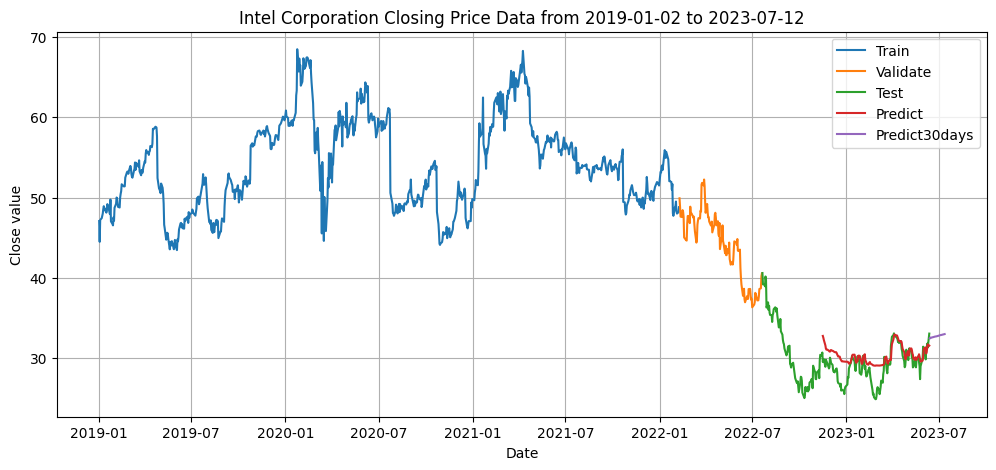

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + loaded_best_window_size: ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_INTC.png')
plt.show()